# ÉVALUATION DE L’ÉQUITÉ DES MODÈLES D’APPRENTISSAGE PROFOND PRÉENTRAÎNÉS
# V. Apprentissage de ResNet50 avec fine tuning, augmentation et balancement
# Projet de 15 crédits de Wajih Mghazli

In [1]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

2023-05-03 18:54:00.623258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 18:54:00.863102: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-03 18:54:04.446878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/export/livia/home/vision/Wmghazli/miniconda3/envs/tf/lib/:/export/livia/home/vision/W

## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)

In [2]:
FEATURES_PATH = 'dataset/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = 'dataset/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = 'dataset/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données

In [3]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, True)

### 1. 3 Initialisation des sous-groupes

In [4]:
train_images_gender, train_labels_gender, train_images_race, train_labels_race = RAFDB_subgroups_init()

### 1. 4. 1 Séparation des sous-groupes (pour la visualisation)

In [5]:
train_images_gender['male'] = np.array(raf_db['images_gender']['male'])
train_labels_gender['male'] = np.array(raf_db['labels_gender']['male'])
train_images_gender['female'] = np.array(raf_db['images_gender']['female'])
train_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])

train_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
train_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
train_images_race['asian'] = np.array(raf_db['images_race']['asian'])
train_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
train_images_race['african'] = np.array(raf_db['images_race']['african'])
train_labels_race['african'] = np.array(raf_db['labels_race']['african'])

## 2. Pré-traitement des données
### 2. 1 Balancement de données avec la méthode d'Over Sampling

In [6]:
# Take the subgroup with the highest number of instances
max_samples = max(
    len(train_images_gender['male']),
    len(train_images_gender['female']),
    len(train_images_race['asian']),
    len(train_images_race['caucasian']),
    len(train_images_race['african'])
)

In [7]:
# Over sampling gender subgroup
for gender in ['male', 'female']:
    if len(train_images_gender[gender]) > max_samples:
        indices = np.random.choice(len(train_images_gender[gender]), max_samples, replace=False)
        train_images_gender[gender] = train_images_gender[gender][indices]
        train_labels_gender[gender] = train_labels_gender[gender][indices]
    elif len(train_images_gender[gender]) < max_samples:
        num_samples = max_samples - len(train_images_gender[gender])
        indices = np.random.choice(len(train_images_gender[gender]), num_samples, replace=True)
        train_images_gender[gender] = np.concatenate((train_images_gender[gender], train_images_gender[gender][indices]))
        train_labels_gender[gender] = np.concatenate((train_labels_gender[gender], train_labels_gender[gender][indices]))

In [8]:
# Over sampling race subgroup
for race in train_images_race.keys():
    num_samples = len(train_images_race[race])
    if num_samples < max_samples:
        num_samples_to_add = max_samples - num_samples
        random_indices = np.random.choice(num_samples, num_samples_to_add)
        train_images_race[race] = np.concatenate((train_images_race[race], train_images_race[race][random_indices]), axis=0)
        train_labels_race[race] = np.concatenate((train_labels_race[race], train_labels_race[race][random_indices]), axis=0)

### 2. 2 Reconstruction de la base de données

In [11]:
# Combine the subgroups into a single dataset
train_images = np.concatenate((train_images_gender['male'], train_images_gender['female'], train_images_race['caucasian'], train_images_race['asian'], train_images_race['african']), axis=0)
train_labels = np.concatenate((train_labels_gender['male'], train_labels_gender['female'], train_labels_race['caucasian'], train_labels_race['asian'], train_labels_race['african']), axis=0)

## 3. Augmentation de la base de données

In [12]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create an instance of the ImageDataGenerator class with the desired data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20, # Rotate images randomly by 20 degrees
    width_shift_range=0.1, # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Shift images vertically by up to 10% of the height
    shear_range=0.2, # Apply shearing transformation with a maximum shear of 20%
    zoom_range=0.2, # Randomly zoom in and out by 20%
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest' # Fill any empty pixels with the nearest value
)

# Fit the ImageDataGenerator to the training data
datagen.fit(train_images)

## 4. Apprentissage de ResNet50 avec fine tuning, augmentation et balancement

In [14]:
# Instantiate the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

# Add a global average pooling layer and a dense layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top 10 layers (fine tuning)
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
batch_size = 32
steps_per_epoch = train_images.shape[0] // batch_size
validation_steps = val_images.shape[0] // batch_size

train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size, shuffle=True)
val_generator = datagen.flow(val_images, val_labels, batch_size=batch_size, shuffle=False)

2023-05-03 18:58:59.426490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 18:59:02.075837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46705 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-05-03 18:59:02.078397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46705 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:31:00.0, compute capability: 8.6
2023-05-03 18:59:02.080147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/t

In [15]:
# Define checkpoint and early stopping callbacks
checkpoint_dir = './checkpoints'
checkpoint_file = checkpoint_dir + '/best_aumented_balanced_resnet50.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_file, monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=300, validation_data=val_generator, validation_steps=validation_steps, callbacks=[checkpoint, early_stop], verbose=1)

Epoch 1/300


2023-05-03 18:59:50.921337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-03 18:59:52.405149: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-03 18:59:54.810816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1173/1173 [==============================] - 512s 426ms/step - loss: 1.0294 - accuracy: 0.6294 - val_loss: 0.8657 - val_accuracy: 0.6932
Epoch 2/300
1173/1173 [==============================] - 499s 425ms/step - loss: 0.7544 - accuracy: 0.7307 - val_loss: 0.7181 - val_accuracy: 0.7437
Epoch 3/300
1173/1173 [==============================] - 502s 428ms/step - loss: 0.6107 - accuracy: 0.7839 - val_loss: 0.6316 - val_accuracy: 0.7790
Epoch 4/300
1173/1173 [==============================] - 495s 422ms/step - loss: 0.5232 - accuracy: 0.8147 - val_loss: 0.5670 - val_accuracy: 0.7985
Epoch 5/300
1173/1173 [==============================] - 502s 428ms/step - loss: 0.4625 - accuracy: 0.8360 - val_loss: 0.5045 - val_accuracy: 0.8259
Epoch 6/300
1173/1173 [==============================] - 496s 422ms/step - loss: 0.4061 - accuracy: 0.8587 - val_loss: 0.4758 - val_accuracy: 0.8355
Epoch 7/300
1173/1173 [==============================] - 491s 418ms/step - loss: 0.3662 - accuracy: 0.8716 - val_loss:

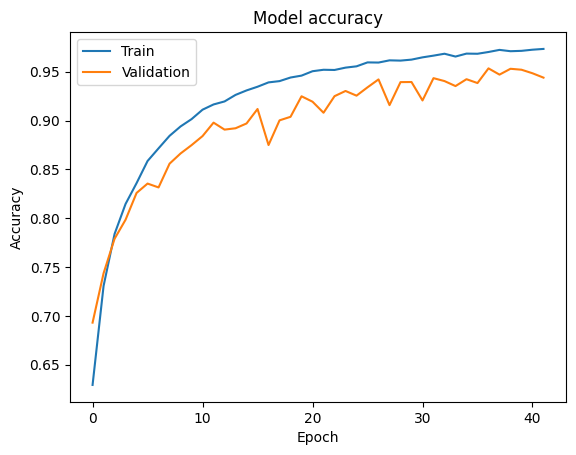

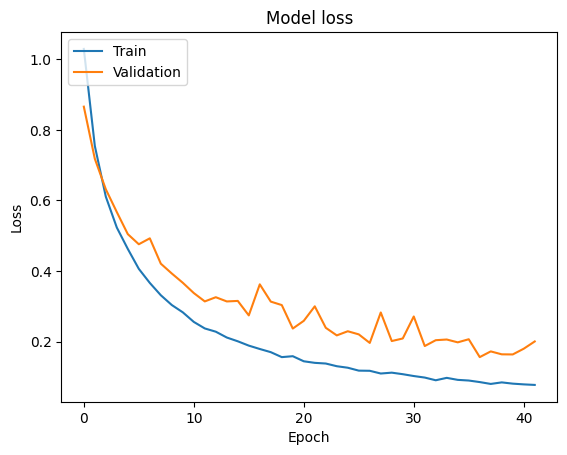

In [17]:
# Plot the accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()